### **BOF SCENE CLASSIFICATION by Combining Local and Global Image Descriptors**

 **Install, Import, and Load Dataset**

**Install required python package**

In [ ]:
!pip install urllib3
!pip install resumable-urlretrieve

**Import Libraries**

In [ ]:

### import required libraries ###
### file/folder manipulation ###

# from urllib import urlretrieve
from os import listdir
from os.path import isfile, join, exists
from zipfile import ZipFile
##for random split of dataset into a training set and a test set ###
from sklearn.model_selection import train_test_split
## image processing routines for feature extraction/transformation##
from skimage.feature import daisy,hog
from skimage import io
from skimage.color import rgb2gray
import skimage
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn import svm

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import seaborn as sn

import matplotlib.pyplot as plt
%matplotlib inline

**Download Dataset**

In [ ]:
!rm -rf UCMerced_LandUse

In [ ]:
if not exists('UCMerced_LandUse/'):
    if not exists('UCMerced_LandUse.zip'):
        print('Downloading UCMerced_LandUse.zip')
        !wget http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
        print('Downloaded UCMerced_LandUse.zip')
    print('Extracting UCMerced_LandUse.zip')
    zipfile = ZipFile('UCMerced_LandUse.zip', 'r')
    zipfile.extractall('./')
    zipfile.close()
    print('Extracted UCMerced_LandUse.zip')
else:
    print('Dataset already downloaded and extracted!')

Extracting UCMerced_LandUse.zip
Extracted UCMerced_LandUse.zip


In [ ]:
# !unzip UCMerced_LandUse.zip

**Get all the filenames (including the full path) in a folder as a list**

In [ ]:
def get_filenames(path):
    onlyfiles = [path+f for f in listdir(path) if isfile(join(path, f))]
    return onlyfiles


**Function to extract daisy features as well as hog features from an image**

In [ ]:

def extract_daisy_and_hog_features_from_image(file_path,daisy_step_size=32,daisy_radius=32,hog_pixels_per_cell=16,hog_cells_per_block=1):
    img = io.imread(file_path)
    img_gray = rgb2gray(img)
    img=skimage.transform.resize(img_gray,(300,250)) ##resize to a suitable dimension, avg size of images in the dataset
    #original, histograms=6
    descs = daisy(img, step=daisy_step_size, radius=daisy_radius, rings=2, histograms=8,orientations=8, visualize=False)
    #calculate daisy feature descriptors
    descs_num = descs.shape[0] * descs.shape[1]
    daisy_desriptors=descs.reshape(descs_num,descs.shape[2])
    hog_desriptor=hog(img, orientations=8, pixels_per_cell=(hog_pixels_per_cell, hog_pixels_per_cell),cells_per_block=(hog_cells_per_block, hog_cells_per_block), visualize=False,feature_vector=True)
    return daisy_desriptors,hog_desriptor

In [ ]:
def plot_file(fname):
    img_data=plt.imread(fname)
    plt.imshow(rgb2gray(img_data),cmap='Greys_r')

DAISY descriptor size: (1080, 136)
HOG descriptor size: (2160,)


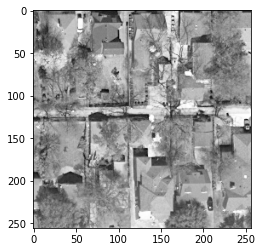

In [ ]:
base_path="UCMerced_LandUse/Images/" ##path where image data is kept
## take a descriptor sample to show the shape of arrays ##
fname="mediumresidential/mediumresidential00.tif"
plot_file(base_path+fname)
#img_data=plt.imread(base_path+fname)
#plt.imshow(rgb2gray(img_data),cmap='Greys_r')
daisy_sample,hog_sample=extract_daisy_and_hog_features_from_image(base_path+fname,daisy_step_size=8,daisy_radius=8)
print('DAISY descriptor size:',daisy_sample.shape)
print('HOG descriptor size:',hog_sample.shape)

In [ ]:
img_width=300
img_height=250
hog_pixels_per_cell=16
orientations=8
print('HOG vector size=',(img_width/hog_pixels_per_cell)*(img_height/hog_pixels_per_cell)*orientations)

HOG vector size= 2343.75


**Load file names corresponding to each scene category into lists**

In [ ]:
category_names=listdir(base_path) ##
for i in range(len(category_names)):
    print(category_names[i],'=',i)
print('total categories:',len(category_names))
dataset_filenames=[] ##list to keep path of all files in the database
dataset_labels=[]
##category_names.index('store')  list the numeric representation of the category
##category_names[0] list the text representation of the category id
for category in category_names:
    category_filenames=get_filenames(base_path+category+"/")##get all the filenames in that category
    category_labels=np.ones(len(category_filenames))*category_names.index(category) ##label the category with its index position
    dataset_filenames=dataset_filenames+category_filenames
    dataset_labels=dataset_labels+list(category_labels)

buildings = 0
overpass = 1
parkinglot = 2
airplane = 3
golfcourse = 4
beach = 5
baseballdiamond = 6
intersection = 7
sparseresidential = 8
runway = 9
chaparral = 10
agricultural = 11
storagetanks = 12
freeway = 13
harbor = 14
denseresidential = 15
mediumresidential = 16
tenniscourt = 17
river = 18
mobilehomepark = 19
forest = 20
total categories: 21


In [ ]:
print('total dataset size:',len(dataset_filenames))

total dataset size: 2100


**Split into training files and testing files**

In [ ]:

train_filenames,test_filenames,train_labels,test_labels=train_test_split(dataset_filenames,dataset_labels,test_size=0.3,random_state=42)
print('total files in training split:',len(train_filenames))
print('total files in testing split:',len(test_filenames))

total files in training split: 1470
total files in testing split: 630


**Extract features from training datasplit for downstream processing**

In [ ]:
training_data_feature_map={} ##map to store daisy feature as well as hog feature for all training datapoints
daisy_descriptor_list=[] ##list to store all daisy descriptors to form our visual vocabulary by clustering
counter=0
for fname in tqdm(train_filenames):
    daisy_features,hog_feature=extract_daisy_and_hog_features_from_image(fname,daisy_step_size=8,daisy_radius=8)
    ###extract DAISY features and HOG features from the image and save in a map###
    training_data_feature_map[fname]=[daisy_features,hog_feature]
    daisy_descriptor_list=daisy_descriptor_list+list(daisy_features)

100%|██████████| 1470/1470 [05:21<00:00,  4.57it/s]


In [ ]:

print('Total daisy descriptors:',len(daisy_descriptor_list))

Total daisy descriptors: 1587600


In [ ]:
def cluster_daisy_features(daisy_feature_list,number_of_clusters):
    #km=KMeans(n_clusters=number_of_clusters)
    km=MiniBatchKMeans(n_clusters=number_of_clusters,batch_size=number_of_clusters*10)
    km.fit(daisy_feature_list)
    return km

In [ ]:
### hide warnings ##
import warnings
warnings.filterwarnings('ignore')

In [ ]:
daisy_cluster_model=cluster_daisy_features(daisy_descriptor_list,600) 
daisy_cluster_model.n_clusters

600

In [ ]:
def extract_daisy_hog_hybrid_feature_from_image(fname,daisy_cluster_model):
    #incase if we have encountered the file during training, the daisy and hog features would already have been computed
    if fname in training_data_feature_map:
        daisy_features=training_data_feature_map[fname][0]
        hog_feature=training_data_feature_map[fname][1]
    else:
        daisy_features,hog_feature=extract_daisy_and_hog_features_from_image(fname,daisy_step_size=8,daisy_radius=8)
        
    ##find to which clusters each daisy feature belongs
    img_clusters=daisy_cluster_model.predict(daisy_features) 
    cluster_freq_counts=pd.DataFrame(img_clusters,columns=['cnt'])['cnt'].value_counts()
    bovw_vector=np.zeros(daisy_cluster_model.n_clusters) ##feature vector of size as the total number of clusters
    for key in cluster_freq_counts.keys():
        bovw_vector[key]=cluster_freq_counts[key]

    bovw_feature=bovw_vector/np.linalg.norm(bovw_vector)
    hog_feature=hog_feature/np.linalg.norm(hog_feature)
    return list(bovw_feature)+list(hog_feature)

In [ ]:
XTRAIN=[]
YTRAIN=[]
for i in tqdm(range(len(train_filenames))):
    XTRAIN.append(extract_daisy_hog_hybrid_feature_from_image(train_filenames[i],daisy_cluster_model))
    YTRAIN.append(train_labels[i])

100%|██████████| 1470/1470 [00:22<00:00, 65.26it/s]


Hybrid Classifier

In [ ]:
hybrid_classifier=svm.SVC(C=10**1.6794140624999994, gamma=10**-0.1630955304365928, decision_function_shape='ovo',probability=True) #cross-validated hyper-parameters
hybrid_classifier.fit(XTRAIN,YTRAIN)

SVC(C=47.798477392518556, decision_function_shape='ovo',
    gamma=0.6869173242795459, probability=True)

true label: 13.0
prediction: [9.]


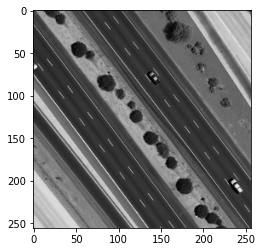

In [ ]:
### show a sample classification ###
plot_file(test_filenames[3])
print('true label:',test_labels[3])
hybrid_feature_vector=extract_daisy_hog_hybrid_feature_from_image(test_filenames[3],daisy_cluster_model)
print('prediction:',hybrid_classifier.predict([hybrid_feature_vector]))

Prediction: [20.]


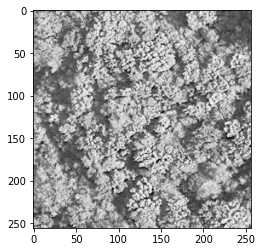

In [ ]:
### show a sample classification on external file ###
external_file_name="/content/UCMerced_LandUse/Images/forest/forest20.tif"
plot_file(external_file_name)
hybrid_feature_vector=extract_daisy_hog_hybrid_feature_from_image(external_file_name,daisy_cluster_model)
print('Prediction:',hybrid_classifier.predict([hybrid_feature_vector]))

In [ ]:
### testing data feature extraction ###, do only for 200 instances if a quick test is required
XTEST=[]
YTEST=[]
for i in tqdm(range(len(test_filenames))):
    XTEST.append(extract_daisy_hog_hybrid_feature_from_image(test_filenames[i],daisy_cluster_model))
    YTEST.append(test_labels[i])

100%|██████████| 630/630 [02:20<00:00,  4.49it/s]


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

KNN Classifier

In [ ]:
knn_hybrid_classifier=KNeighborsClassifier(n_neighbors=3)
knn_hybrid_classifier.fit(XTRAIN,YTRAIN)

KNeighborsClassifier(n_neighbors=3)

true label: 16.0
prediction: [16.]


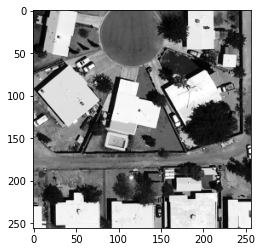

In [ ]:
### show a sample classification ###
plot_file(test_filenames[9])
print('true label:',test_labels[9])
hybrid_feature_vector=extract_daisy_hog_hybrid_feature_from_image(test_filenames[9],daisy_cluster_model)
print('prediction:',knn_hybrid_classifier.predict([hybrid_feature_vector]))

# **K FOLD CROSS VALIDATION**
The dataset is split into ‘k’ number of subsets, k-1 subsets then are used to train the model and the last subset is kept as a validation set to test the model. Then the score of the model on each fold is averaged to evaluate the performance of the model.In this case K is 10.

In [ ]:
# <<<<<<<<<<<<<<KFOLD CROSS VALIDATION>>>>>>>>>>>>>>>
from sklearn.model_selection import cross_val_score
def cross_validation_fun(models,XTEST,YTEST):
  kfold=cross_val_score(models,XTEST,YTEST,cv=10,scoring="accuracy").mean()
  print("Kfold Accuracy is:     ",kfold*100,"%")

## **ACCURACY**

 PLOT CONFUSION MATRIX

In [ ]:
import seaborn as sns

In [ ]:
def plot(y_true,y_pred):
  columns=['storagetanks','runway','tenniscourt','mobilehomepark','airplane','forest','buildings','mediumresidential','intersection','freeway','sparseresidential','golfcourse','chaparral','denseresidential','baseballdiamond','river','parkinglot','beach','overpass','harbor','agricultural']
  index=['storagetanks','runway','tenniscourt','mobilehomepark','airplane','forest','buildings','mediumresidential','intersection','freeway','sparseresidential','golfcourse','chaparral','denseresidential','baseballdiamond','river','parkinglot','beach','overpass','harbor','agricultural']
  table=pd.DataFrame(confusion_matrix(y_true,y_pred),columns=columns,index=index)

  fig,ax=plt.subplots(figsize=(10, 10))
  return sns.heatmap(table,annot=True,fmt='d',cmap='Blues',ax=ax)

# Hybrid Classifier:

Hybrid Classifier Mertics
No. of test instances: 630 630
Overall accuracy: 85.23809523809524 %
                   precision    recall  f1-score   support

        buildings       0.87      0.74      0.80        27
         overpass       0.96      0.92      0.94        25
       parkinglot       0.95      0.97      0.96        36
         airplane       0.89      0.82      0.85        39
       golfcourse       0.81      0.81      0.81        36
            beach       0.94      0.92      0.93        37
  baseballdiamond       0.74      0.77      0.75        26
     intersection       0.79      0.85      0.82        27
sparseresidential       0.67      0.79      0.72        28
           runway       0.88      0.81      0.85        27
        chaparral       0.93      0.87      0.90        31
     agricultural       0.90      0.96      0.93        27
     storagetanks       0.65      0.71      0.68        21
          freeway       0.92      0.92      0.92        37
           harbor  

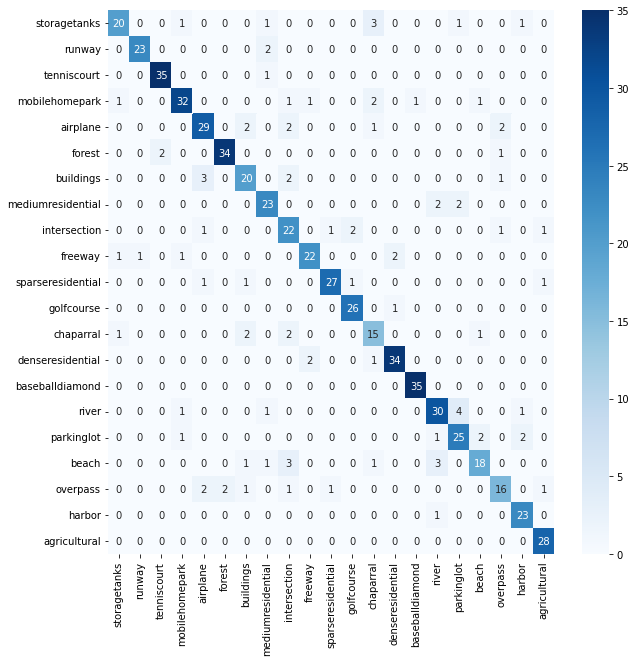

In [ ]:
print('Hybrid Classifier Mertics')
print('No. of test instances:',len(XTEST),len(YTEST))
### Accuracy Report ###
hybridpred=hybrid_classifier.predict(XTEST)
print('Overall accuracy:',accuracy_score(YTEST,hybridpred)*100,"%")
print(classification_report(YTEST, hybridpred, target_names=category_names))
print('Confusion matrix:\n')

plot(YTEST,hybridpred)
plt.savefig("Hybrid Classifier Mertics.png")
# files.download("Hybrid Classifier Mertics.png")
cross_validation_fun(hybrid_classifier,XTRAIN,YTRAIN)


# KNN HYBRID CLASSIFIER:

Hybrid Classifier Mertics
No. of test instances: 630 630
Overall accuracy: 71.42857142857143 %
                   precision    recall  f1-score   support

        buildings       0.77      0.63      0.69        27
         overpass       0.84      0.64      0.73        25
       parkinglot       0.85      0.97      0.91        36
         airplane       0.74      0.64      0.68        39
       golfcourse       0.54      0.72      0.62        36
            beach       0.94      0.86      0.90        37
  baseballdiamond       0.52      0.46      0.49        26
     intersection       0.59      0.70      0.64        27
sparseresidential       0.38      0.57      0.46        28
           runway       0.88      0.85      0.87        27
        chaparral       0.84      0.87      0.86        31
     agricultural       0.83      0.93      0.88        27
     storagetanks       0.60      0.43      0.50        21
          freeway       0.97      0.86      0.91        37
           harbor  

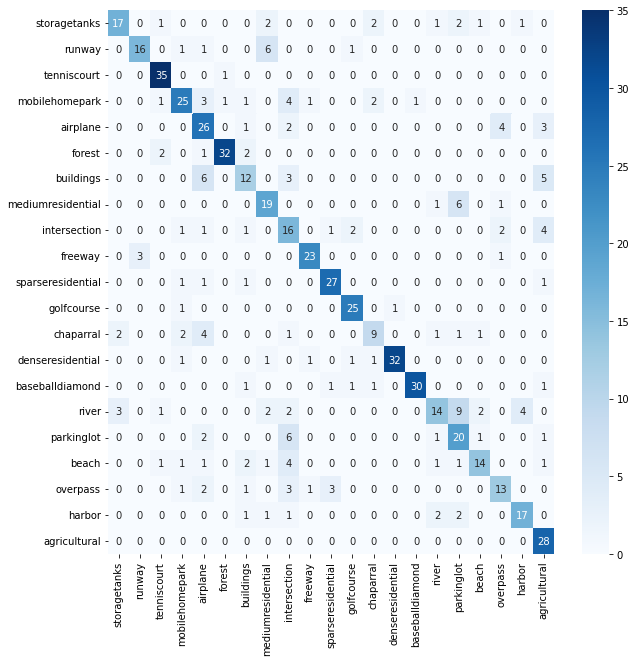

In [ ]:
print('Hybrid Classifier Mertics')
print('No. of test instances:',len(XTEST),len(YTEST))
### Accuracy Report ###
hybridpred2=knn_hybrid_classifier.predict(XTEST)
print('Overall accuracy:',accuracy_score(YTEST,hybridpred2)*100,"%")
print(classification_report(YTEST, hybridpred2, target_names=category_names))
print('Confusion matrix:\n')

plot(YTEST,hybridpred2)
plt.savefig("KNN Classifier Mertics.png")
# files.download("Hybrid Classifier Mertics.png")
cross_validation_fun(knn_hybrid_classifier,XTRAIN,YTRAIN)

# Linear Classifier:

In [ ]:
#### TRAIN A linear SVM CLASSIFIER and GET ACCURACY REPORT ###
hybrid_classifier_SVM=svm.LinearSVC()
hybrid_classifier_SVM.fit(XTRAIN,YTRAIN)

LinearSVC()

Hybrid Classifier Mertics - Linear SVM
No. of test instances: 630 630
Overall accuracy: 83.01587301587303 %
                   precision    recall  f1-score   support

        buildings       0.95      0.70      0.81        27
         overpass       0.88      0.92      0.90        25
       parkinglot       0.90      0.97      0.93        36
         airplane       0.97      0.82      0.89        39
       golfcourse       0.85      0.81      0.83        36
            beach       0.90      0.95      0.92        37
  baseballdiamond       0.61      0.73      0.67        26
     intersection       0.80      0.89      0.84        27
sparseresidential       0.75      0.64      0.69        28
           runway       0.86      0.93      0.89        27
        chaparral       0.93      0.87      0.90        31
     agricultural       0.81      0.96      0.88        27
     storagetanks       0.64      0.76      0.70        21
          freeway       0.97      0.81      0.88        37
      

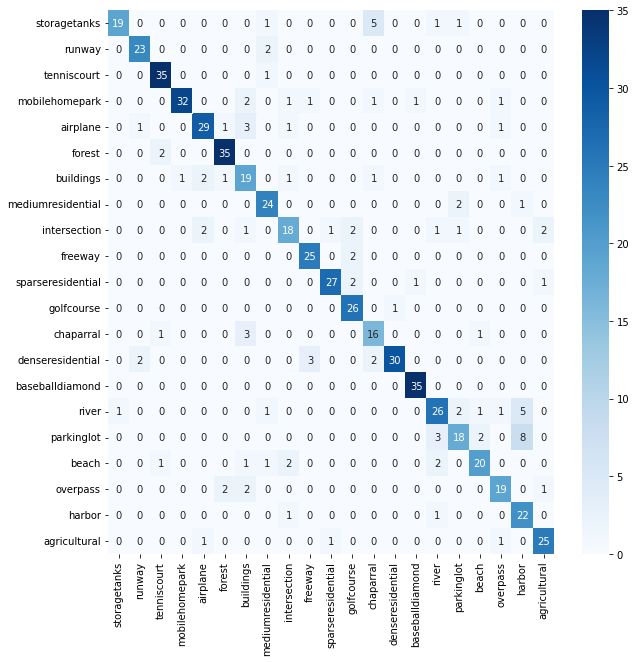

In [ ]:
print('Hybrid Classifier Mertics - Linear SVM')
print('No. of test instances:',len(XTEST),len(YTEST))
### Accuracy Report ###
hybridpred=hybrid_classifier_SVM.predict(XTEST)
print('Overall accuracy:',accuracy_score(YTEST,hybridpred)*100,"%")
print(classification_report(YTEST, hybridpred, target_names=category_names))
print('Confusion matrix:\n')

plot(YTEST,hybridpred)
plt.savefig("Linear Classifier.png")
# files.download("Hybrid Classifier Mertics - Linear SVM.png")
cross_validation_fun(hybrid_classifier_SVM,XTRAIN,YTRAIN)


# HOG only:

In [ ]:
XTRAIN_HOG=[]
for X in XTRAIN:
    XTRAIN_HOG.append(X[daisy_cluster_model.n_clusters:])

In [ ]:
XTEST_HOG=[]
for X in XTEST:
    XTEST_HOG.append(X[daisy_cluster_model.n_clusters:])

In [ ]:
#### TRAIN HOG only CLASSIFIER and GET ACCURACY REPORT ###
hogclassifier=svm.LinearSVC()
hogclassifier.fit(XTRAIN_HOG,YTRAIN)

LinearSVC()

HOG Only Classifier Mertics
No. of test instances: 630 630
Overall 10 fold accuracy: 33.96825396825397 %
                   precision    recall  f1-score   support

        buildings       0.26      0.33      0.30        27
         overpass       0.67      0.88      0.76        25
       parkinglot       0.60      0.08      0.15        36
         airplane       0.50      0.21      0.29        39
       golfcourse       0.00      0.00      0.00        36
            beach       0.55      0.32      0.41        37
  baseballdiamond       0.35      0.69      0.46        26
     intersection       0.52      0.89      0.66        27
sparseresidential       0.24      0.14      0.18        28
           runway       0.46      0.85      0.60        27
        chaparral       0.11      0.13      0.12        31
     agricultural       0.53      0.67      0.59        27
     storagetanks       0.17      0.38      0.24        21
          freeway       0.75      0.41      0.53        37
         

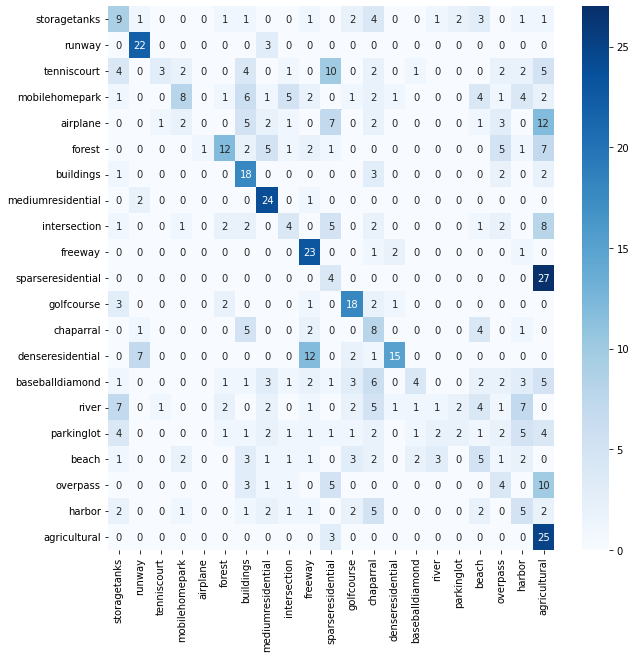

In [ ]:
print('HOG Only Classifier Mertics')
print('No. of test instances:',len(XTEST_HOG),len(YTEST))
### Accuracy Report ###
pred=hogclassifier.predict(XTEST_HOG)
print('Overall 10 fold accuracy:',accuracy_score(YTEST,pred)*100,"%")
print(classification_report(YTEST, pred, target_names=category_names))
print('Confusion matrix:\n')

plot(YTEST,pred)
plt.savefig("HOG Only Classifier Mertics.png")
# files.download("Hybrid Classifier Mertics - Linear SVM.png")
cross_validation_fun(hogclassifier,XTRAIN_HOG,YTRAIN)

# DAISY only:

In [ ]:
XTRAIN_DAISY=[]
for X in XTRAIN:
    XTRAIN_DAISY.append(X[:daisy_cluster_model.n_clusters])

In [ ]:
XTEST_DAISY=[]
for X in XTEST:
    XTEST_DAISY.append(X[:daisy_cluster_model.n_clusters])

In [ ]:
#### TRAIN DAISY only CLASSIFIER and GET ACCURACY REPORT ###
daisyclassifier=svm.LinearSVC()
daisyclassifier.fit(XTRAIN_DAISY,YTRAIN)

LinearSVC()

HOG Only Classifier Mertics
No. of test instances: 630 630
Overall accuracy: 78.88888888888889 %
                   precision    recall  f1-score   support

        buildings       0.95      0.67      0.78        27
         overpass       0.83      0.80      0.82        25
       parkinglot       0.92      0.97      0.95        36
         airplane       0.97      0.79      0.87        39
       golfcourse       0.77      0.75      0.76        36
            beach       0.87      0.92      0.89        37
  baseballdiamond       0.57      0.65      0.61        26
     intersection       0.50      0.63      0.56        27
sparseresidential       0.65      0.61      0.63        28
           runway       0.83      0.89      0.86        27
        chaparral       0.93      0.87      0.90        31
     agricultural       0.83      0.93      0.88        27
     storagetanks       0.54      0.67      0.60        21
          freeway       0.94      0.78      0.85        37
           harbor

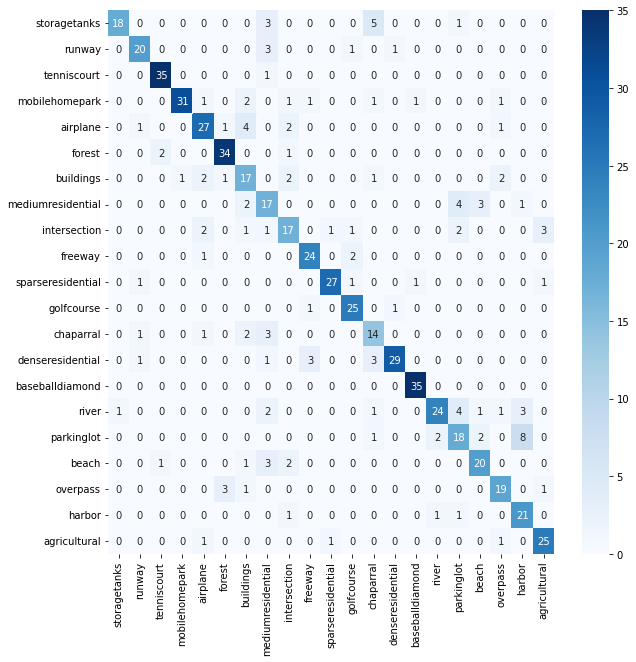

In [ ]:
print('HOG Only Classifier Mertics')
print('No. of test instances:',len(XTEST_DAISY),len(YTEST))
### Accuracy Report ###
pred = daisyclassifier.predict(XTEST_DAISY)
print('Overall accuracy:',accuracy_score(YTEST,pred)*100,"%")
print(classification_report(YTEST, pred, target_names=category_names))
print('Confusion matrix:\n')

plot(YTEST,pred)
plt.savefig("Daisy Only Classifier Mertics.png")
# files.download("Hybrid Classifier Mertics - Linear SVM.png")
cross_validation_fun(daisyclassifier,XTRAIN_DAISY,YTRAIN)

## **ROC CURVE FOR THE MODELS:**

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
sns.set(palette="hls", context='talk')

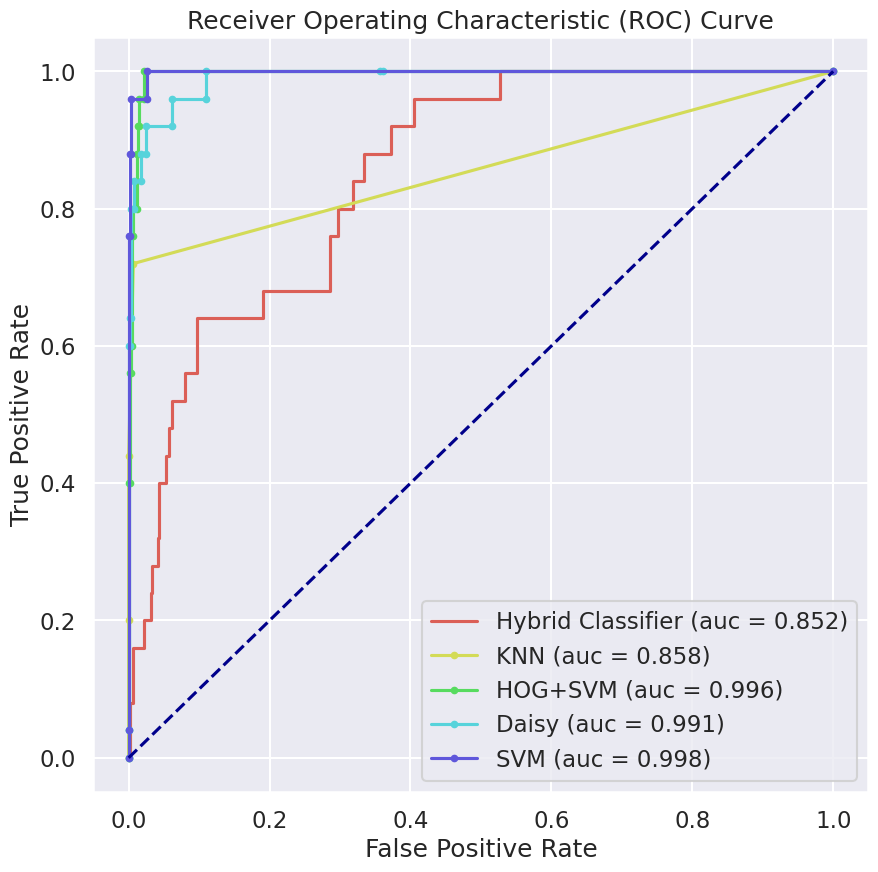

In [ ]:

hybrid_YPRED = hybrid_classifier.decision_function(XTEST)
hybrid_YPRED=hybrid_YPRED[:,1]
hybrid_fpr, hybrid_tpr, hybrid_threshold = roc_curve(YTEST, hybrid_YPRED,pos_label=1)
hybrid_auc = auc(hybrid_fpr, hybrid_tpr)
# 1
Knn_YPRED = knn_hybrid_classifier.predict_proba(XTEST)
Knn_YPRED=Knn_YPRED[:,1]
Knn_fpr, Knn_tpr, Knn_threshold = roc_curve(YTEST, Knn_YPRED,pos_label=1)
Knn_auc = auc(Knn_fpr, Knn_tpr)
# 2
Daisy_YPRED = daisyclassifier.decision_function(XTEST_DAISY)
Daisy_YPRED=Daisy_YPRED[:,1]
Daisy_fpr, Daisy_tpr, Daisy_threshold = roc_curve(YTEST, Daisy_YPRED,pos_label=1)
Daisy_auc = auc(Daisy_fpr, Daisy_tpr)
# 3
Hog_YPRED = hogclassifier.decision_function(XTEST_HOG)
Hog_YPRED=Hog_YPRED[:,1]
Hog_fpr, Hog_tpr, Hog_threshold = roc_curve(YTEST, Hog_YPRED,pos_label=1)
Hog_auc = auc(Hog_fpr, Hog_tpr)
# 4
SVM_YPRED = hybrid_classifier_SVM.decision_function(XTEST)
SVM_YPRED=SVM_YPRED[:,1]
SVM_fpr, SVM_tpr, SVM_threshold = roc_curve(YTEST, SVM_YPRED,pos_label=1)
SVM_auc = auc(SVM_fpr, SVM_tpr)
# 5
plt.figure(figsize=(10, 10), dpi=100)
plt.plot(hybrid_fpr, hybrid_tpr, linestyle='-', label='Hybrid Classifier (auc = %0.3f)' % hybrid_auc)
plt.plot(Knn_fpr, Knn_tpr, marker='.', label='KNN (auc = %0.3f)' % Knn_auc)
plt.plot(Hog_fpr, Hog_tpr, marker='.', label='HOG+SVM (auc = %0.3f)' % Hog_auc)
plt.plot(Daisy_fpr, Daisy_tpr, marker='.', label='Daisy (auc = %0.3f)' % Daisy_auc)
plt.plot(SVM_fpr, SVM_tpr, marker='.', label='SVM (auc = %0.3f)' % SVM_auc)

plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.savefig("ROC Curve.png")
plt.show()